In [ ]:
require(gridExtra)
library(xcms)
library(RColorBrewer)
library(dplyr)
library(reshape2)
library(magrittr)
library(pheatmap)
library(ggplot2)
library(ggtext)
library(enviPat)
library(stringr)
data(isotopes)

**File source definitions**

In [2]:
fileSrc <- Sys.glob("/data/comcon1/ketoacids/mzmls/c13*.mzML")
fileSrc %>% as.list

[[1]]
[1] "/data/comcon1/ketoacids/mzmls/c13dminu1-1.mzML"

[[2]]
[1] "/data/comcon1/ketoacids/mzmls/c13dminu1-2.mzML"

[[3]]
[1] "/data/comcon1/ketoacids/mzmls/c13dminu2-1.mzML"

[[4]]
[1] "/data/comcon1/ketoacids/mzmls/c13dminu2-2.mzML"

[[5]]
[1] "/data/comcon1/ketoacids/mzmls/c13dplus1-1.mzML"

[[6]]
[1] "/data/comcon1/ketoacids/mzmls/c13dplus1-2.mzML"

[[7]]
[1] "/data/comcon1/ketoacids/mzmls/c13dplus2-1.mzML"

[[8]]
[1] "/data/comcon1/ketoacids/mzmls/c13dplus2-2.mzML"

[[9]]
[1] "/data/comcon1/ketoacids/mzmls/c13dplus3-1.mzML"

[[10]]
[1] "/data/comcon1/ketoacids/mzmls/c13dplus3-2.mzML"

[[11]]
[1] "/data/comcon1/ketoacids/mzmls/c13mminu1-1.mzML"

[[12]]
[1] "/data/comcon1/ketoacids/mzmls/c13mminu1-2.mzML"

[[13]]
[1] "/data/comcon1/ketoacids/mzmls/c13mminu2-1.mzML"

[[14]]
[1] "/data/comcon1/ketoacids/mzmls/c13mminu2-2.mzML"

[[15]]
[1] "/data/comcon1/ketoacids/mzmls/c13mminu3-1.mzML"

[[16]]
[1] "/data/comcon1/ketoacids/mzmls/c13mminu3-2.mzML"

[[17]]
[1] "/data/comcon1/ketoacids/mzmls/c13mplus1-1.mzML"

[[18]]
[1] "/data/comcon1/ketoacids/mzmls/c13mplus1-2.mzML"

[[19]]
[1] "/data/comcon1/ketoacids/mzmls/c13mplus2-1.mzML"

[[20]]
[1] "/data/comcon1/ketoacids/mzmls/c13mplus2-2.mzML"

[[21]]
[1] "/data/comcon1/ketoacids/mzmls/c13mplus3-1.mzML"

[[22]]
[1] "/data/comcon1/ketoacids/mzmls/c13mplus3-2.mzML"

**Conditions for files**

In [3]:
fileConds <- c("d1","d2","d3","d4",
               "D1","D2","D3","D4","D5","D6",
               "m1","m2","m3","m4","m5","m6",
               "M1","M2","M3","M4","M5","M6")

**Pallettee definitions**

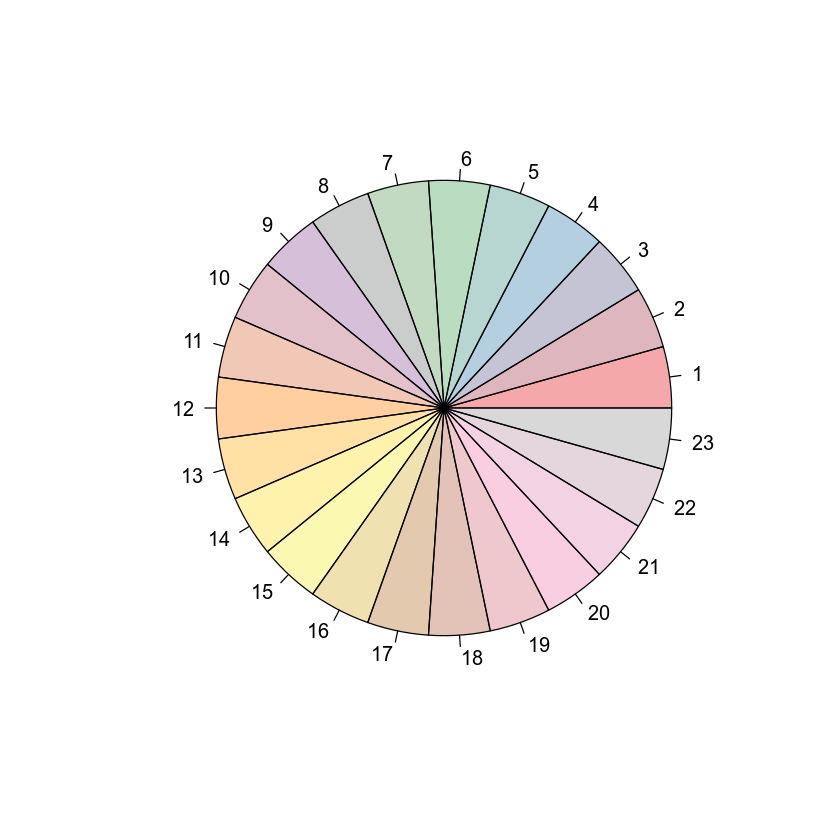

In [4]:
group_colors <- paste0(colorRampPalette( brewer.pal(9, "Set1") )(23) [1:23], "60")
names(group_colors) <- fileConds
pie(rep(1, length(group_colors)), col = group_colors , main="")

**Define common functions**

In [82]:
#' genChrom: convert a chromatogram object to data.frame 
#'
#' @param chr Chromatogram (S4)
#' @param annot DataFrame with 'sample_name' column
#'
#' @return DataFrame suitable for further plotting with ggplot2
#'
genChrom <- function(chr, annot) {
    alls <- data.frame(rtime=double(), intensity=double(), cond=integer())
    for (v in 1:nrow(annot)) {
        alls <- rbind( alls, 
                           chr[1,v] %>% 
                           as.data.frame %>% 
                           set_rownames(seq(length(bpis[1,v]))) %>% 
                           mutate(cond = v)
              )
    }
    alls <- alls %>% mutate(cond = as.factor(cond))

    # replace num with annotations
    alls$cond <- alls$cond %>%
                    plyr::mapvalues(from=1:nrow(annot), to=annot$sample_name) %>%
                    as.factor
    
    # Add annotation labels specific for our data
    alls <- alls %>% 
                mutate(e.ann = ifelse(grepl("plus", cond), "+DAla", "-DAla")) %>%
                mutate(e.ann = as.factor(e.ann)) %>%
                mutate(cond = as.factor(cond))
    
    return(alls)
}

#' genPData make peak table with isotopomeric information 
#'
#' @param data Chromatogram (S4)
#' @param annot DataFrame with 'sample_name' column
#' @pPat Theoretic isotopic pattern for the substance built by enviPat
#' @nMeres How many isotopes to analyze?
#' @threshold An allowed mass shift.
#'
#' @return DataFrame suitable for further plotting with ggplot2
#'
genPData <- function(data, annot, pPat, nMeres, threshold=0.002) {
    pData <- NULL

    for (i in 1:nMeres) {
        mzr <- pPat[i,"m/z"] + c(-threshold, +threshold)
        bpis <- chromatogram(data, mz=mzr, aggregationFun = "max" )
        pIs <- chromPeaks(bpis) %>% as.data.frame
        pIs["isotope"] <- i-1
        pIs["isotope.ann"] <- paste0("M+",i-1)
        pIs["sample.ann"] <- annot[pIs$sample,"sample_group"]
        if (is.null(pData)) {
            pData <- pIs }
        else {
            pData <- rbind(pData, pIs)
        }
    }
    return(pData)
}

#' preparePlotImer generate a melted DataFrame for isotopomeric distribtution
#' @param data Output from genPData
#' @param pPat Theoretic isotopic pattern for the substance built by enviPat
#' 
#' @return a melted array for immediate plotting.
#'
preparePlotImer <- function(data, pPat) {

    pDataFin <- data %>% 
        select(intb,isotope,sample.ann) %>%
        transform(isotope = as.integer(isotope)) %>%
        dcast(sample.ann ~ paste0('M.',isotope), value.var = 'intb', fun.aggregate = sum) 
    rownames(pDataFin) <- pDataFin$sample.ann
    
    pRes <- pDataFin %>% 
        select(-sample.ann) %>%
        mutate_at(vars(starts_with("M.")), ~ . / pDataFin$`M.0` * 100.0 )

    maxM <- pRes %>% names %>% sapply(function(x) { return(sub("M.","",x)) } ) %>% last %>% as.integer

    pPlt <- pRes %>% 
        as.matrix %>% melt %>% 
        mutate(Var1 = as.character(Var1)) %>%
        mutate(cond = as.character(str_match(Var1, 'D|d|M|m')),
               rep = as.integer(str_match(Var1, '\\d')),
               ismer = paste0("M+",str_match(Var2,'\\d')) ) %>%
        select(-Var1, -Var2) %>%
        rbind(
            data.frame( value = akgPat$abundance[0:maxM+1] ,
                        cond = 'R', rep = 0, ismer = paste0("M+", 0:maxM) ) )

    return(pPlt)
}


**Theoretic distributions**

In [6]:
pyruvate = "C9H9O2N2"
pattern <- isopattern(
  isotopes, pyruvate,
  threshold=0.1, plotit=FALSE,
  charge=FALSE, emass=0.00054858,
  algo=1
)
pyrPat <- pattern$C9H9O2N2 %>% as.data.frame %>% filter(`15N` == 0 & `18O` == 0 & `2H` == 0)
pyrPat

akg = "C11H11O4N2"
pattern<-isopattern(
  isotopes,
  akg,
  threshold=0,
  plotit=FALSE,
  charge=FALSE,
  emass=0.00054858,
  algo=1
)
akgPat <- pattern$C11H11O4N2 %>% as.data.frame %>% filter(`15N` == 0 & `18O` == 0 & `2H` == 0 & `17O` == 0)
akgPat

 done.

m/z,abundance,12C,13C,1H,2H,14N,15N,16O,18O,17O
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
177.0664025,100.0000000000,9,0,9,0,2,0,2,0,0
178.0697574,9.7341554635,8,1,9,0,2,0,2,0,0
179.0731122,0.4211279226,7,2,9,0,2,0,2,0,0


 done.

m/z,abundance,12C,13C,1H,2H,14N,15N,16O,18O,17O
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
235.0718819,1.000000000e+02,11,0,11,0,2,0,4,0,0
236.0752367,1.189730112e+01,10,1,11,0,2,0,4,0,0
237.0785915,6.433898818e-01,9,2,11,0,2,0,4,0,0
238.0819464,2.087619044e-02,8,3,11,0,2,0,4,0,0
239.0853012,4.515824072e-04,7,4,11,0,2,0,4,0,0
240.0886561,6.837869666e-06,6,5,11,0,2,0,4,0,0
241.0920109,7.395654040e-08,5,6,11,0,2,0,4,0,0
242.0953657,5.713527475e-10,4,7,11,0,2,0,4,0,0
243.0987206,3.089798038e-12,3,8,11,0,2,0,4,0,0


# Pyruvate analysis

> Selecting a proper window scan (< 177).  
Pyruvate was scanned in a frame 176-180 mz.  
See methods file `pyrkgoxa-nofrag-hitemp-acn545`.

In [7]:
pd <- data.frame(sample_name = sub(basename(fileSrc), pattern = ".mzML",
                                   replacement = "", fixed = TRUE),
                 sample_group = fileConds,
                 stringsAsFactors = FALSE)
raw_data <- readMSData(files = fileSrc, pdata = new("NAnnotatedDataFrame", pd),
                       msLevel = 1, mode = "onDisk")

.intermediate <- fData(raw_data) %>% filter(scanWindowLowerLimit  < 177 )
raw_data@featureData@data <- .intermediate
rm(.intermediate)

**Print information about first 3 scans**

In [8]:
fData(raw_data) %>% head(n=3) %>% t

,F01.S0002,F01.S0005,F01.S0008
fileIdx,1,1,1
spIdx,2,5,8
smoothed,NA,NA,NA
seqNum,2,5,8
acquisitionNum,2,5,8
msLevel,1,1,1
polarity,0,0,0
originalPeaksCount,41,81,96
totIonCurrent,339280.81,1822711.10,1922578.50
retentionTime,179.113728,179.679648,180.246012


In [9]:
# CANDIDATES FOR REMOVAL!
# mzs <- mz(raw_data)
# mz_by_file <- split(mzs, f = fromFile(raw_data))

**Plot TIC chromatogram for pyruvate**

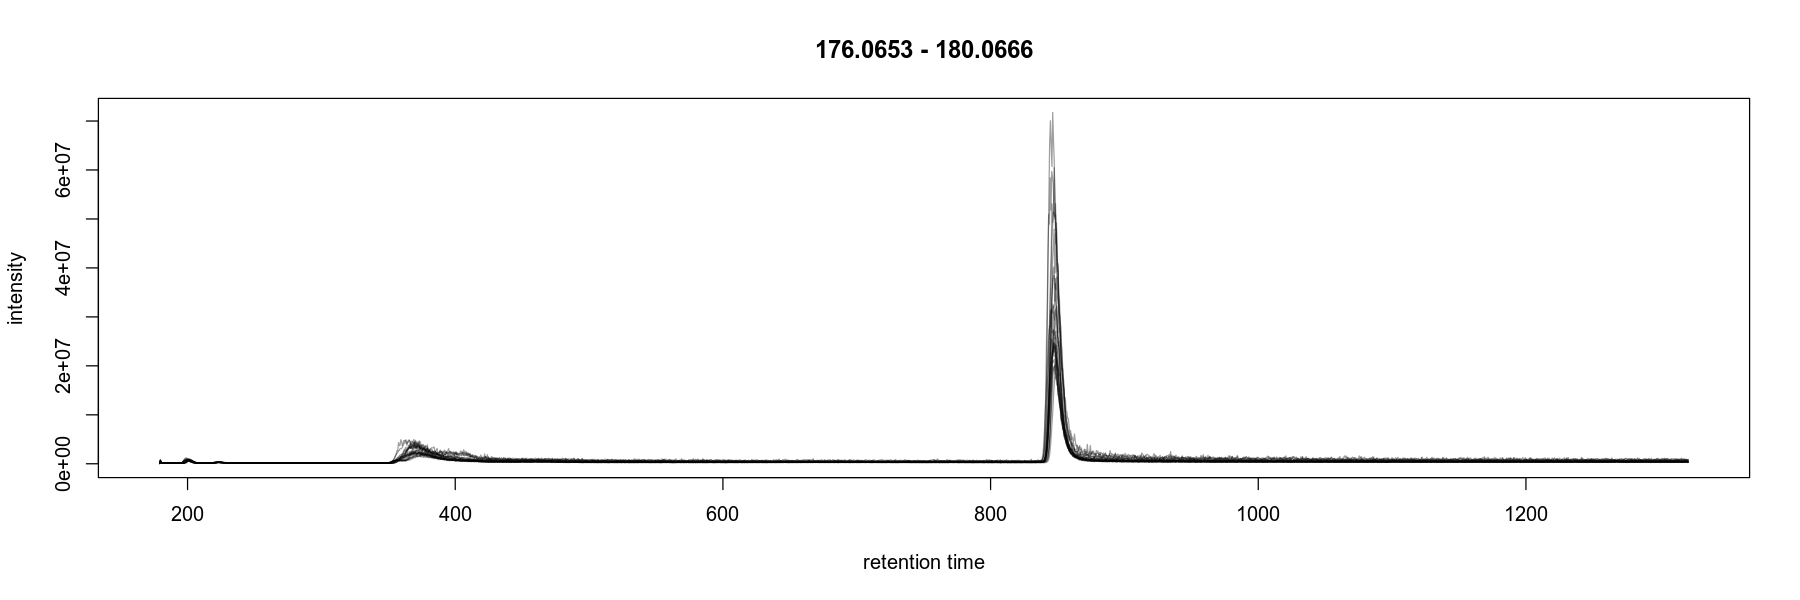

In [10]:
bpis <- chromatogram(raw_data, aggregationFun = "max", BPPARAM = MulticoreParam(workers = 2) )
options(repr.plot.width = 15, repr.plot.height = 5)
plot(bpis)
rm(bpis)

**Deteciting peaks..**  
*Please do not increase number of workers if you don't have a huge RAM.*

In [ ]:
cwp <- CentWaveParam(peakwidth = c(20, 80), noise = 5000,
                     prefilter = c(6, 10000))
xdata <- findChromPeaks(raw_data, param = cwp, BPPARAM = MulticoreParam(workers = 2) )

**Finding an average position of two major peaks**

In [12]:
rts <- ( chromPeaks(xdata) %>% as.data.frame  %>% filter(mz < pyrPat[1,1] + 0.1 & mz > pyrPat[1,1] - 0.1  )  %>% arrange(desc(`into`)) %>% filter(into>1e7) )$rt
hi  <- ( round(rts/3, digits=0)*3 ) %>% hist(plot=FALSE, breaks=(1:100)*10 )
hi2 <- data.frame(breaks = hi$breaks[1:99], den = hi$density) %>% arrange(desc(den))
pyrAvRT <- hi2$breaks[1:2]
cat("First peak: ",  hi2$breaks[[1]], " sec \n")
cat("Second peak: ", hi2$breaks[[2]], " sec \n")
rm(rts,hi,hi2)

First peak:  840  sec 
Second peak:  370  sec 


**Plotting TIC chromatograms:**

Warning message:
“Removed 37786 row(s) containing missing values (geom_path).”
Warning message:
“Removed 39681 row(s) containing missing values (geom_path).”


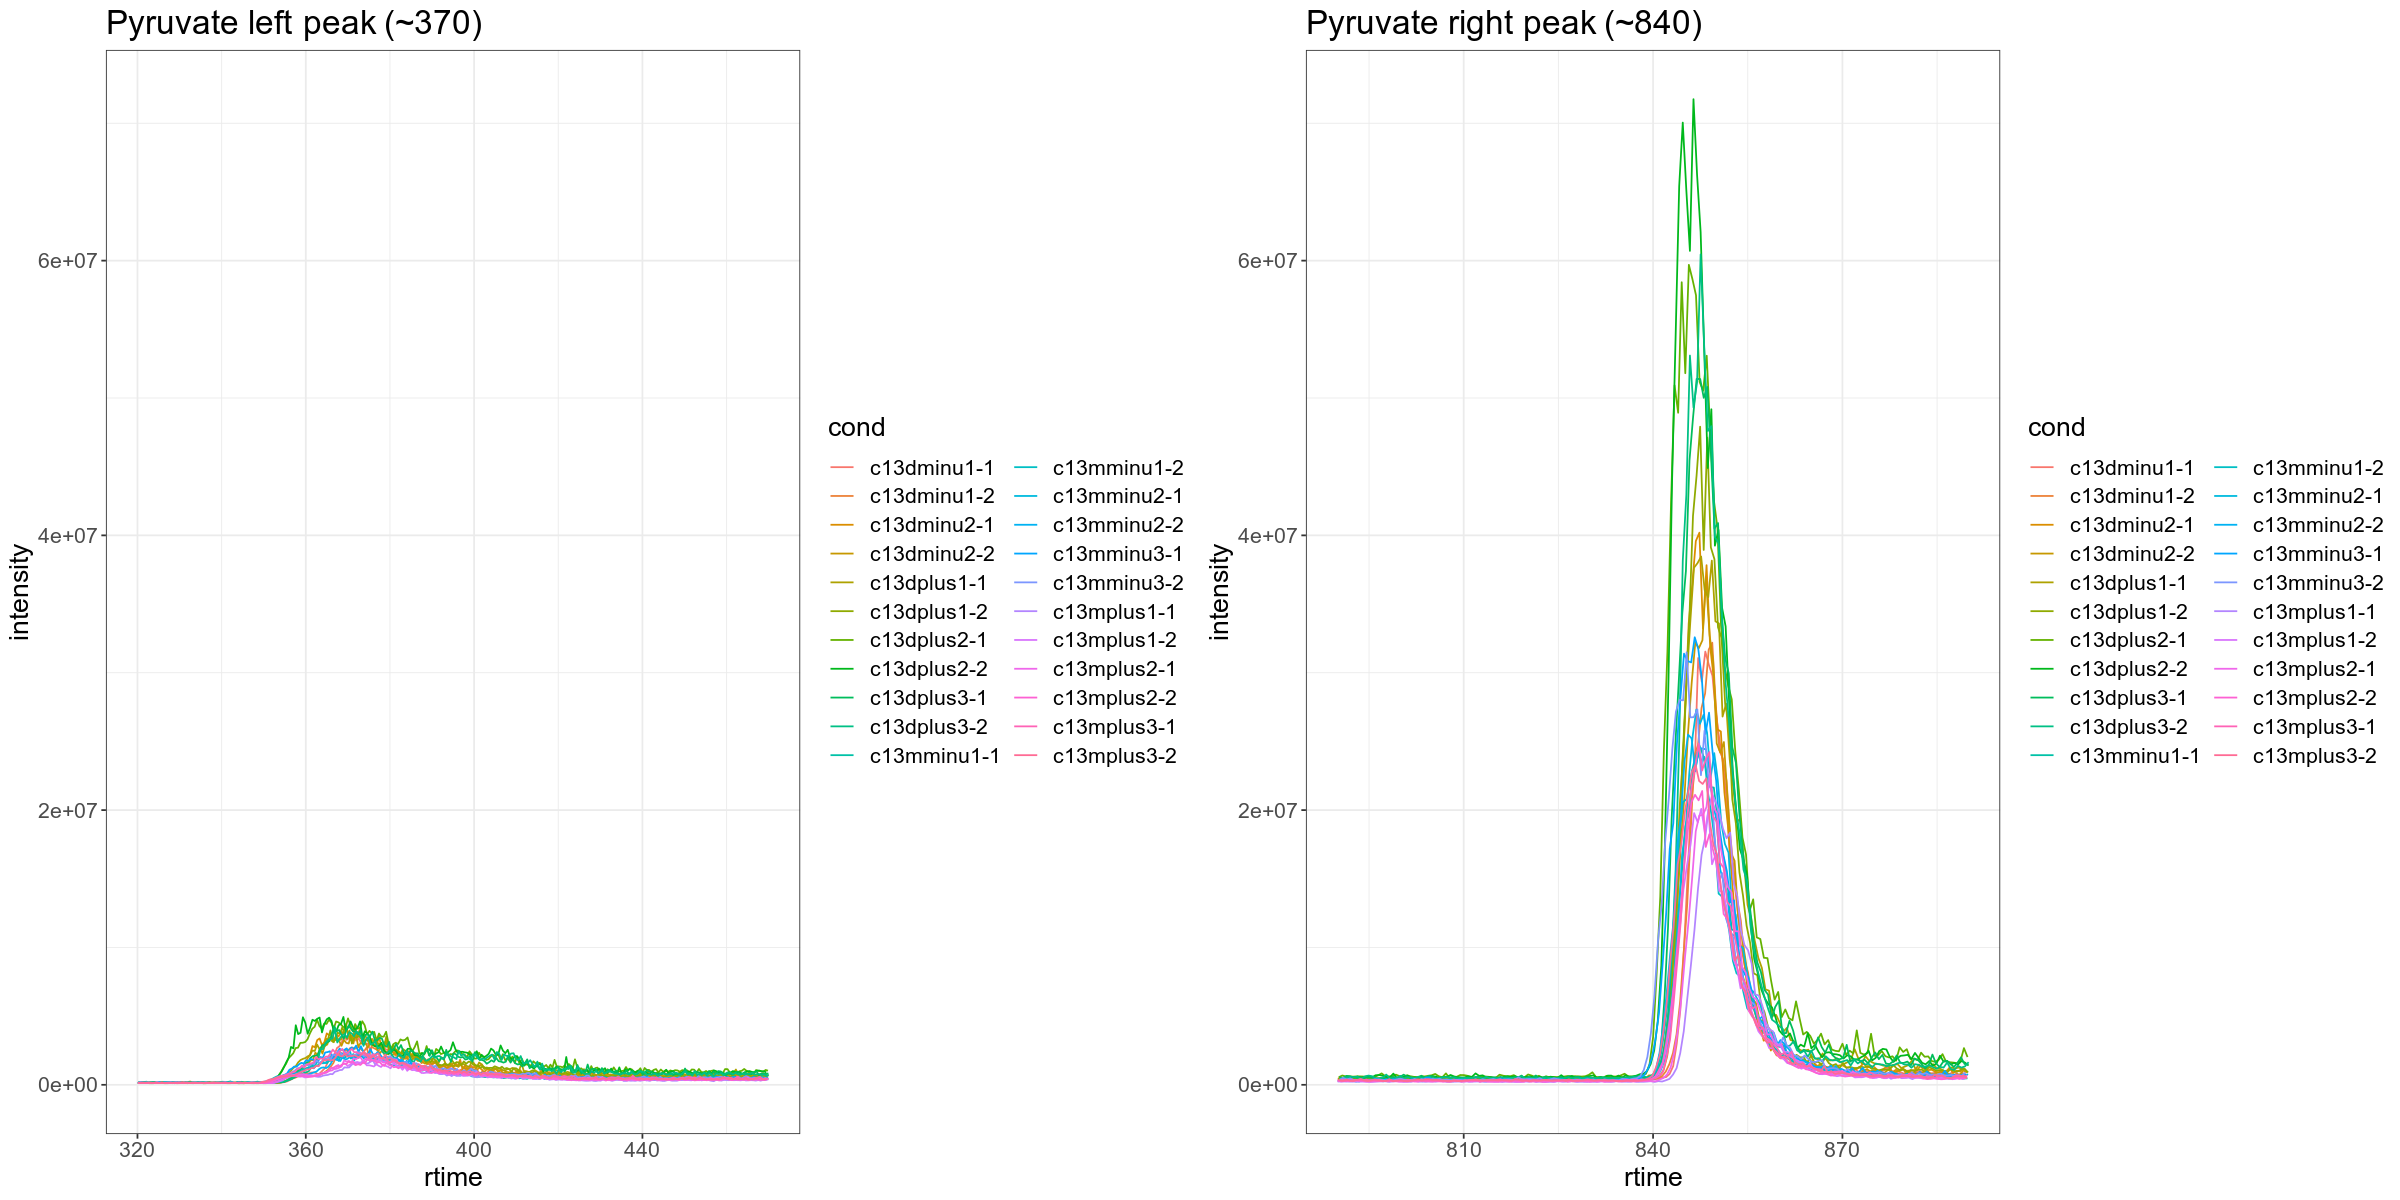

In [13]:
bpis <- chromatogram(xdata, mz=c(100,200), aggregationFun = "max" )
alls <- genChrom(bpis, annot=pd)

options(repr.plot.width = 20, repr.plot.height = 10)
theme <- theme_bw() + theme(text = element_text(size=16), plot.title = element_markdown(size=20))                           
p1 <- alls %>% 
    ggplot( aes(x = rtime, y = intensity, group = cond, color = cond) ) + 
    geom_line(size = 0.5) + xlim( pyrAvRT[[2]]-50, pyrAvRT[[2]]+100) + ylim(0,NA) +
    labs(title=paste0("Pyruvate left peak (~", pyrAvRT[[2]] ,")") ) + theme
p2 <- alls %>% 
    ggplot( aes(x = rtime, y = intensity, group = cond, color = cond) ) + 
    geom_line(size = 0.5) + xlim(pyrAvRT[[1]]-50, pyrAvRT[[1]]+50) + ylim(0,NA) +
    labs(title=paste0("Pyruvate right peak (~", pyrAvRT[[1]] ,")") )  + theme
grid.arrange(p1, p2, ncol=2)
rm(bpis,alls)

*Test different XIC-chromatograms for isotopologues*

Warning message:
“Removed 37786 row(s) containing missing values (geom_path).”
Warning message:
“Removed 39681 row(s) containing missing values (geom_path).”


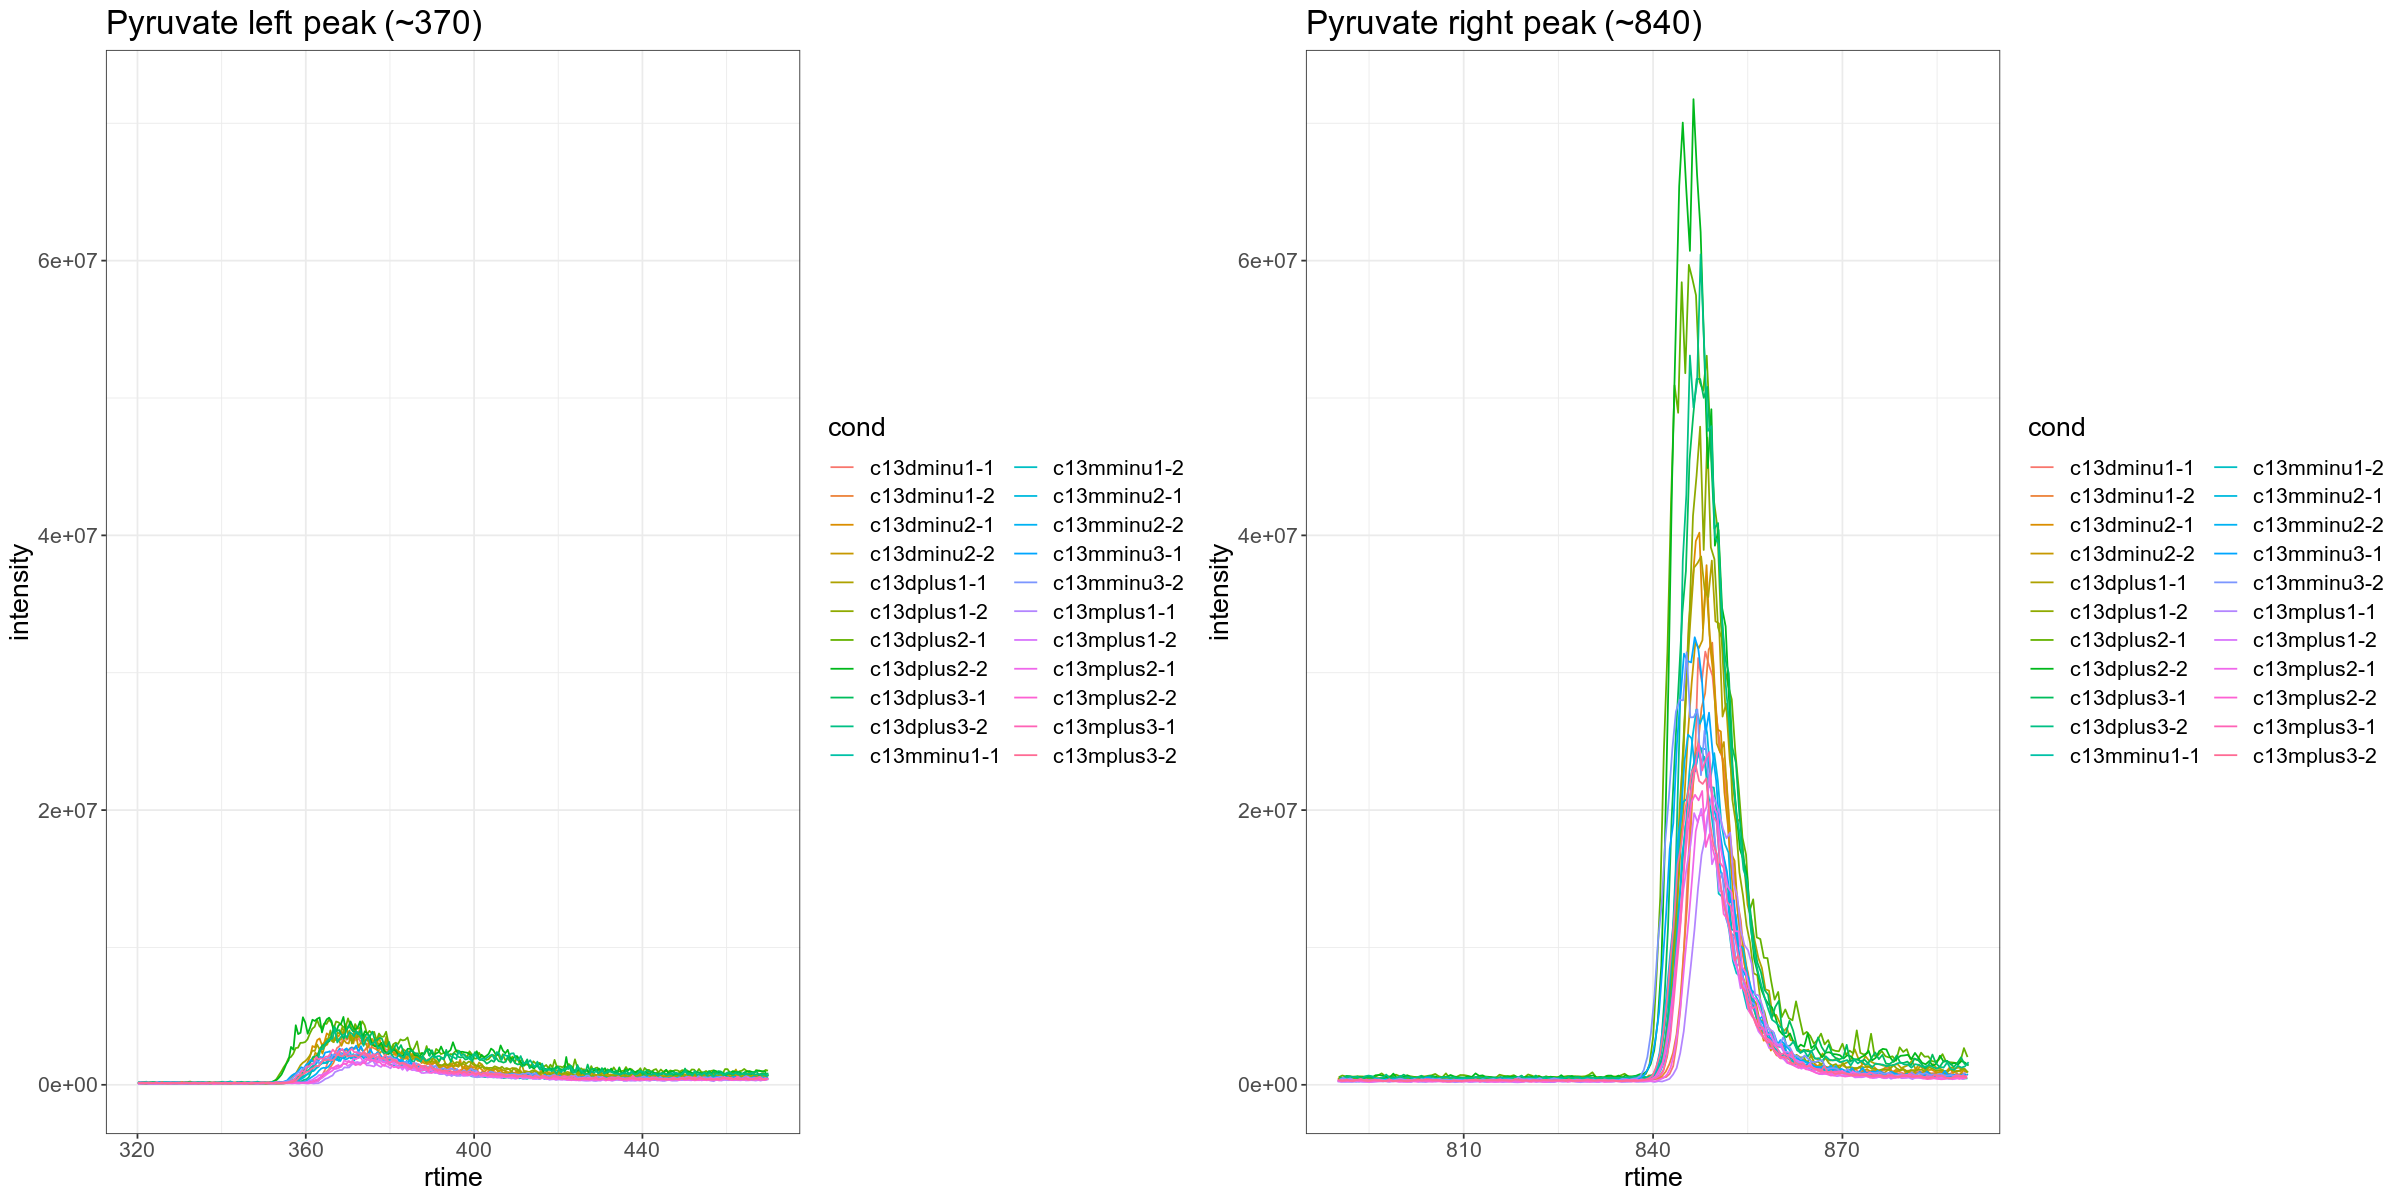

In [14]:
mzr <- pyrPat[1,"m/z"] + c(-0.002, +0.002)
bpis <- chromatogram(xdata, mz=mzr, aggregationFun = "max" )
alls <- genChrom(bpis, annot=pd)


options(repr.plot.width = 20, repr.plot.height = 10)
theme <- theme_bw() + theme(text = element_text(size=16), plot.title = element_markdown(size=20))                           
p1 <- alls %>% 
    ggplot( aes(x = rtime, y = intensity, group = cond, color = cond) ) + 
    geom_line(size = 0.5) + xlim( pyrAvRT[[2]]-50, pyrAvRT[[2]]+100) + ylim(0,NA) +
    labs(title=paste0("Pyruvate left peak (~", pyrAvRT[[2]] ,")") ) + theme
p2 <- alls %>% 
    ggplot( aes(x = rtime, y = intensity, group = cond, color = cond) ) + 
    geom_line(size = 0.5) + xlim(pyrAvRT[[1]]-50, pyrAvRT[[1]]+50) + ylim(0,NA) +
    labs(title=paste0("Pyruvate right peak (~", pyrAvRT[[1]] ,")") )  + theme
grid.arrange(p1, p2, ncol=2)
rm(bpis,alls)

### Calculate iMere distribution

In [15]:
pyrData <- genPData(xdata, pd, pyrPat, 3)

pyrPlt <- pyrData %>% filter(rt > pyrAvRT[[1]] - 50) %>% preparePlotImer(pPat = pyrPat)

pyrPlt %>% tail


,value,cond,rep,ismer
,<dbl>,<chr>,<dbl>,<chr>
64,73.9263331682,M,5,M+2
65,72.5564765822,m,6,M+2
66,73.3091743170,M,6,M+2
67,100.0000000000,R,0,M+0
68,9.7341554635,R,0,M+1
69,0.4211279226,R,0,M+2


## alpha-KG analysis

In [16]:
pd <- data.frame(sample_name = sub(basename(fileSrc), pattern = ".mzML",
                                   replacement = "", fixed = TRUE),
                 sample_group = fileConds,
                 stringsAsFactors = FALSE)
raw_data <- readMSData(files = fileSrc, pdata = new("NAnnotatedDataFrame", pd),
                       msLevel = 1, mode = "onDisk")

.intermediate <- fData(raw_data) %>% filter(scanWindowUpperLimit  > 237)
raw_data@featureData@data <- .intermediate
rm(.intermediate)

In [17]:
fData(raw_data) %>% head(n=3) %>% t

,F01.S0003,F01.S0006,F01.S0009
fileIdx,1,1,1
spIdx,3,6,9
smoothed,NA,NA,NA
seqNum,3,6,9
acquisitionNum,3,6,9
msLevel,1,1,1
polarity,0,0,0
originalPeaksCount,74,92,119
totIonCurrent,231341.08,597887.44,830877.19
retentionTime,179.248458,179.895708,180.461580


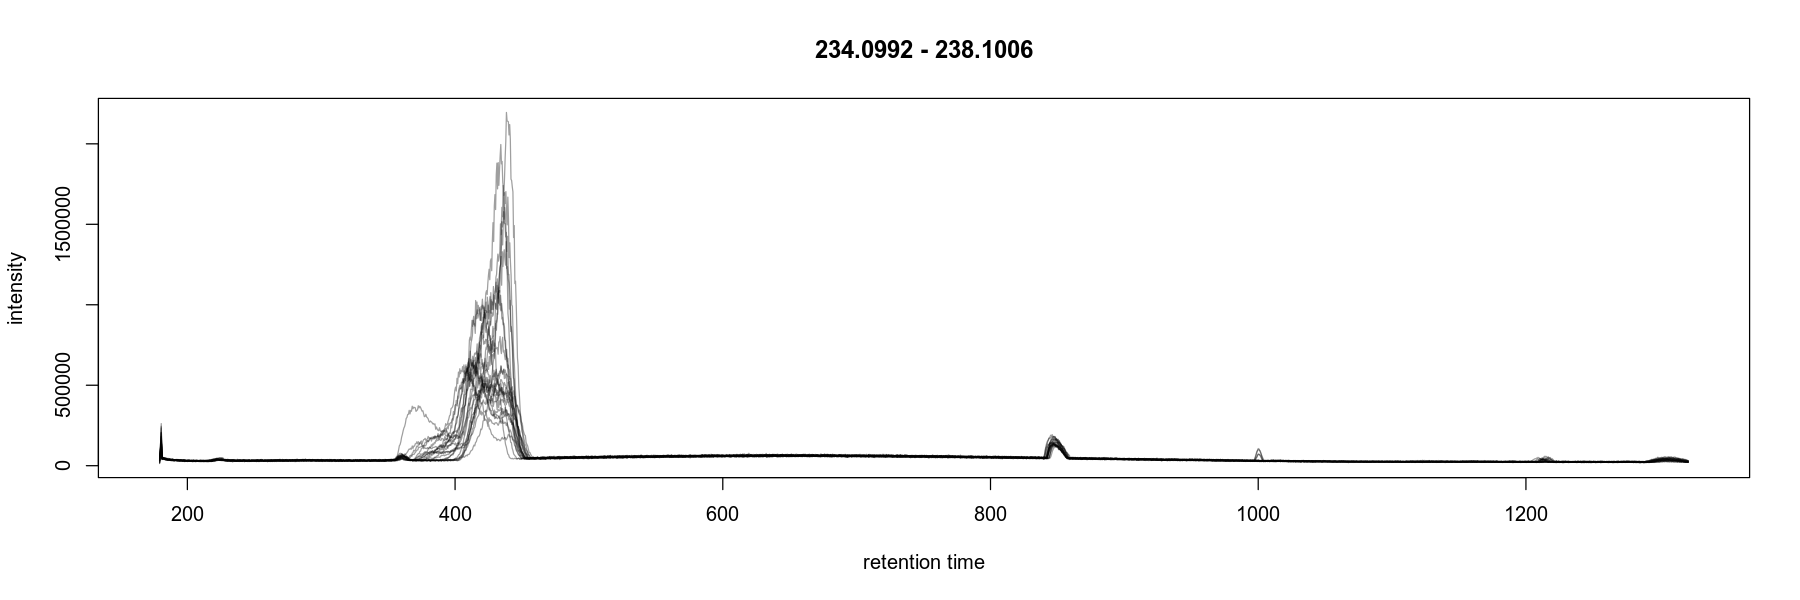

In [18]:
bpis <- chromatogram(raw_data, aggregationFun = "max") 
options(repr.plot.width = 15, repr.plot.height = 5)
plot(bpis)

**Deteciting peaks..**  
*Please do not increase number of workers if you don't have a huge RAM.*

In [ ]:
cwp <- CentWaveParam(peakwidth = c(20, 80), noise = 1000,
                     prefilter = c(1, 500), mzdiff = 0.003)
xdata <- findChromPeaks(raw_data, param = cwp, BPPARAM = MulticoreParam(workers = 2) )

In [20]:
rts <- ( chromPeaks(xdata) %>% as.data.frame  %>% filter(mz < akgPat[1,1] + 0.1 & mz > akgPat[1,1] - 0.1  )  %>% arrange(desc(`into`)) %>% filter(into>1e7) )$rt
hi  <- ( round(rts/3, digits=0)*3 ) %>% hist(plot=FALSE, breaks=(1:100)*10 )
hi2 <- data.frame(breaks = hi$breaks[1:99], den = hi$density) %>% arrange(desc(den))
akgAvRT <- hi2$breaks[1:2]
cat("First peak: ",  hi2$breaks[[1]], " sec \n")
cat("Second peak: ", hi2$breaks[[2]], " sec \n")
rm(rts,hi,hi2)

First peak:  430  sec 
Second peak:  410  sec 


Warning message:
“Removed 39562 row(s) containing missing values (geom_path).”


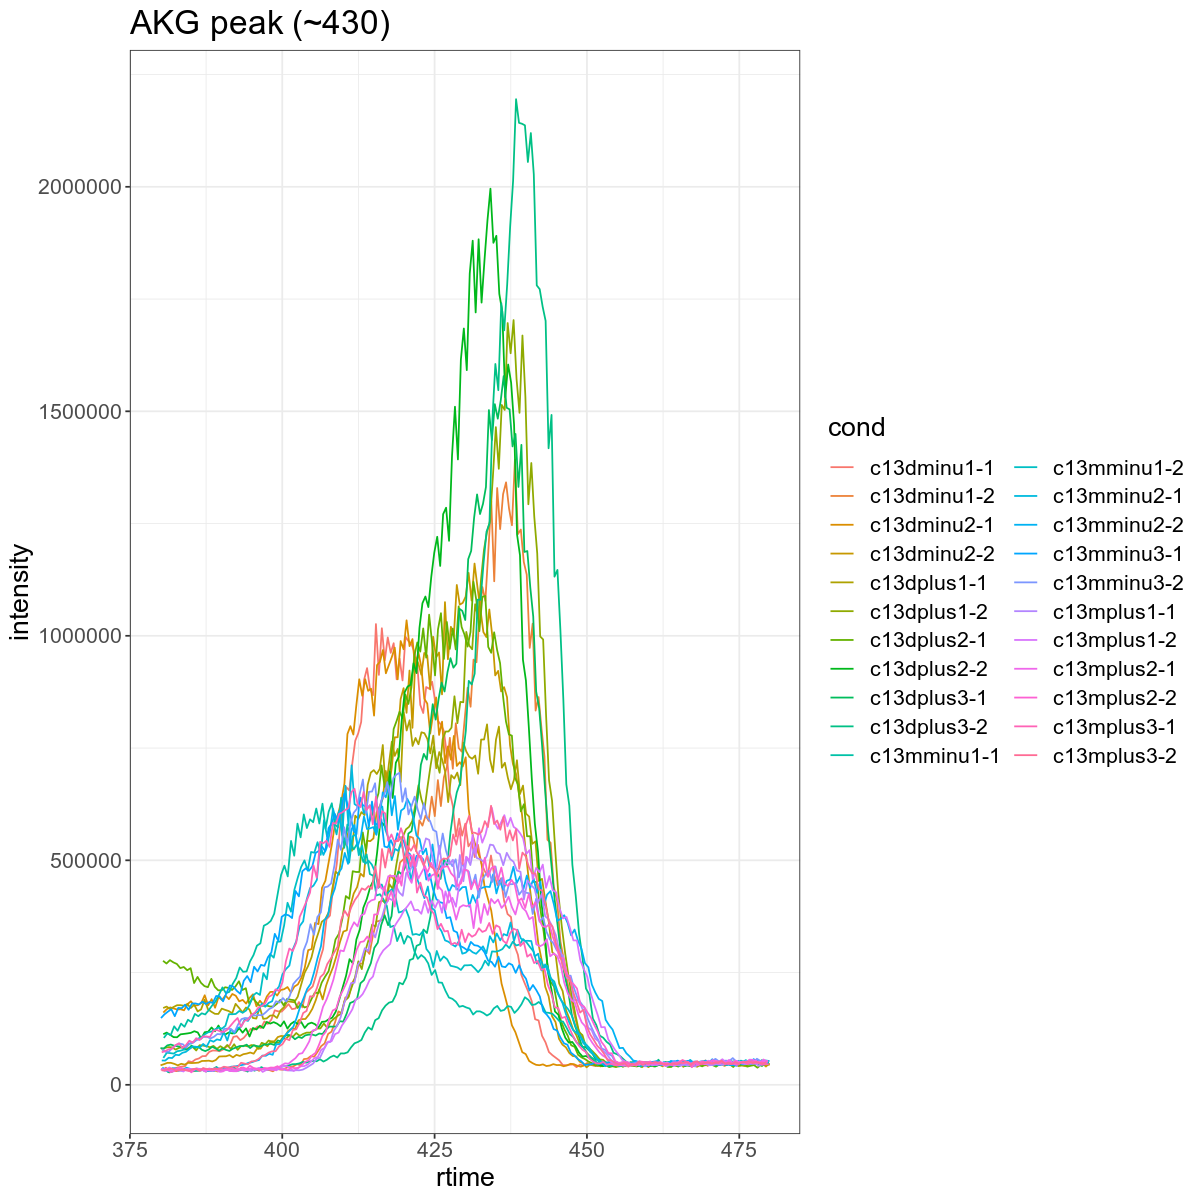

In [21]:
bpis <- chromatogram(xdata, mz=c(100,300), aggregationFun = "max" )
alls <- genChrom(bpis, annot=pd)

options(repr.plot.width = 10, repr.plot.height = 10)
theme <- theme_bw() + theme(text = element_text(size=16), plot.title = element_markdown(size=20))                           
p1 <- alls %>% 
    ggplot( aes(x = rtime, y = intensity, group = cond, color = cond) ) + 
    geom_line(size = 0.5) + xlim( akgAvRT[[1]]-50, akgAvRT[[1]]+50) + ylim(0,NA) +
    labs(title=paste0("AKG peak (~", akgAvRT[[1]] ,")") ) + theme

p1

rm(bpis,alls)

**Test XIC chromatograms for isotopologues**

[1] 235.0688819 235.0748819


Warning message:
“Removed 35802 row(s) containing missing values (geom_path).”


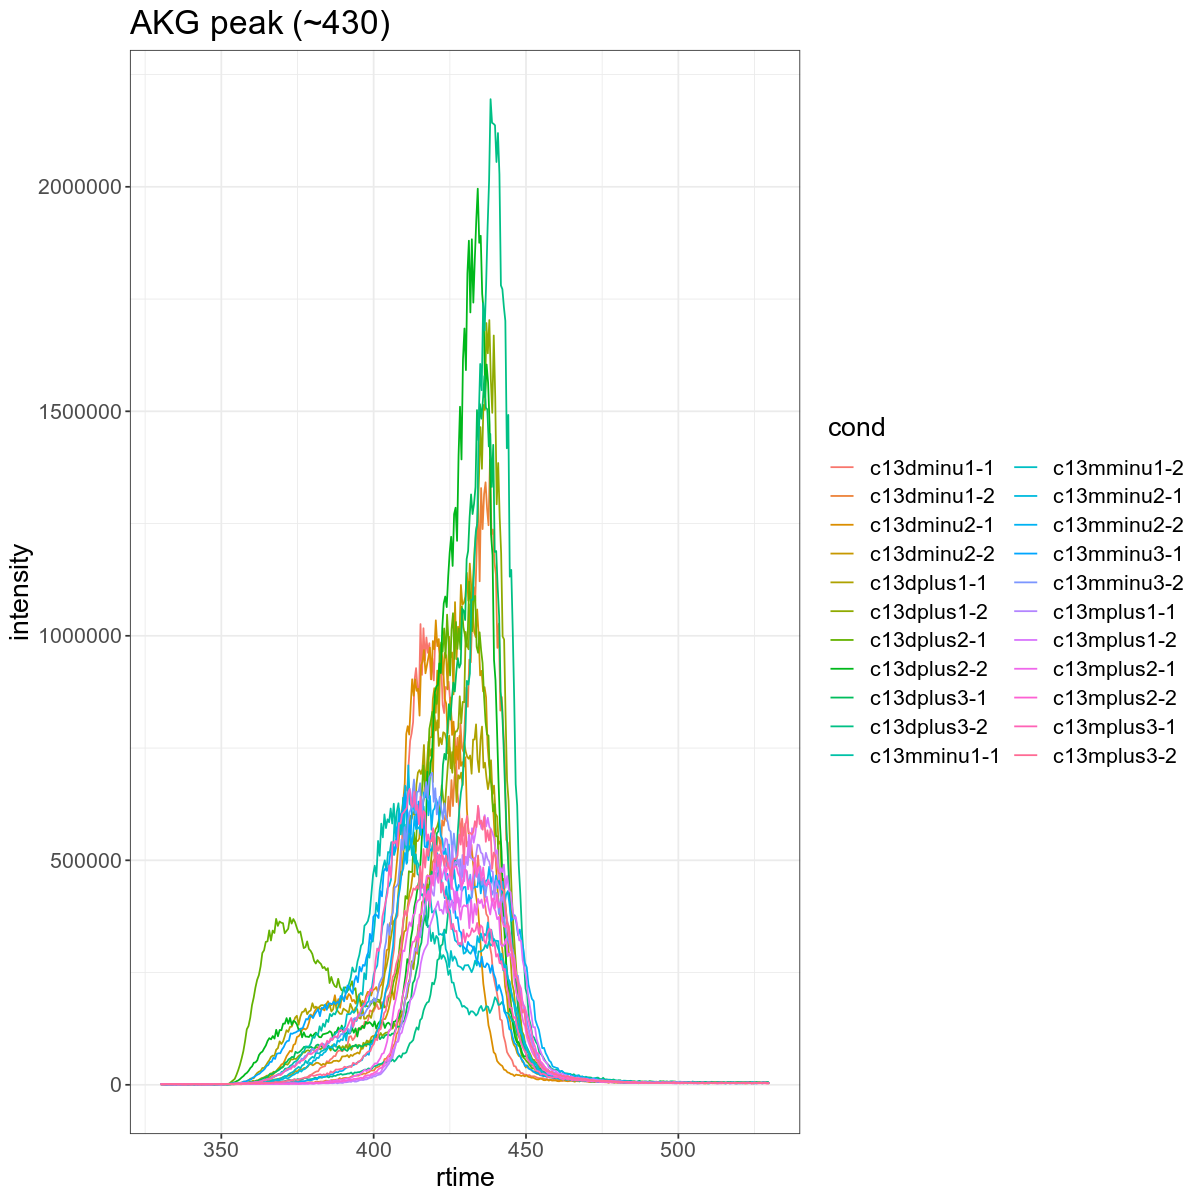

In [71]:
mzr <- akgPat[1,"m/z"] + c(-0.003, +0.003)
print(mzr)
bpis <- chromatogram(xdata, mz=mzr, aggregationFun = "max" )
alls <- genChrom(bpis, annot=pd)

options(repr.plot.width = 10, repr.plot.height = 10)
theme <- theme_bw() + theme(text = element_text(size=16), plot.title = element_markdown(size=20))                           
p1 <- alls %>% 
    ggplot( aes(x = rtime, y = intensity, group = cond, color = cond) ) + 
    geom_line(size = 0.5) + xlim( akgAvRT[[1]]-100, akgAvRT[[1]]+100) + ylim(0,NA) +
    labs(title=paste0("AKG peak (~", akgAvRT[[1]] ,")") ) + theme

p1

rm(bpis,alls)

### Calculate iMere distribution

In [80]:
akgData <- genPData(xdata, pd, akgPat, 4, threshold = 0.003)

akgPlt <- akgData %>% filter(rt<450 & rt > 400) %>% preparePlotImer(pPat = akgPat)

akgPlt %>% tail


,value,cond,rep,ismer
,<dbl>,<chr>,<dbl>,<chr>
87,0.00000000000,m,6,M+3
88,0.00000000000,M,6,M+3
89,100.00000000000,R,0,M+0
90,11.89730112201,R,0,M+1
91,0.64338988176,R,0,M+2
92,0.02087619044,R,0,M+3


# Plot final distributions

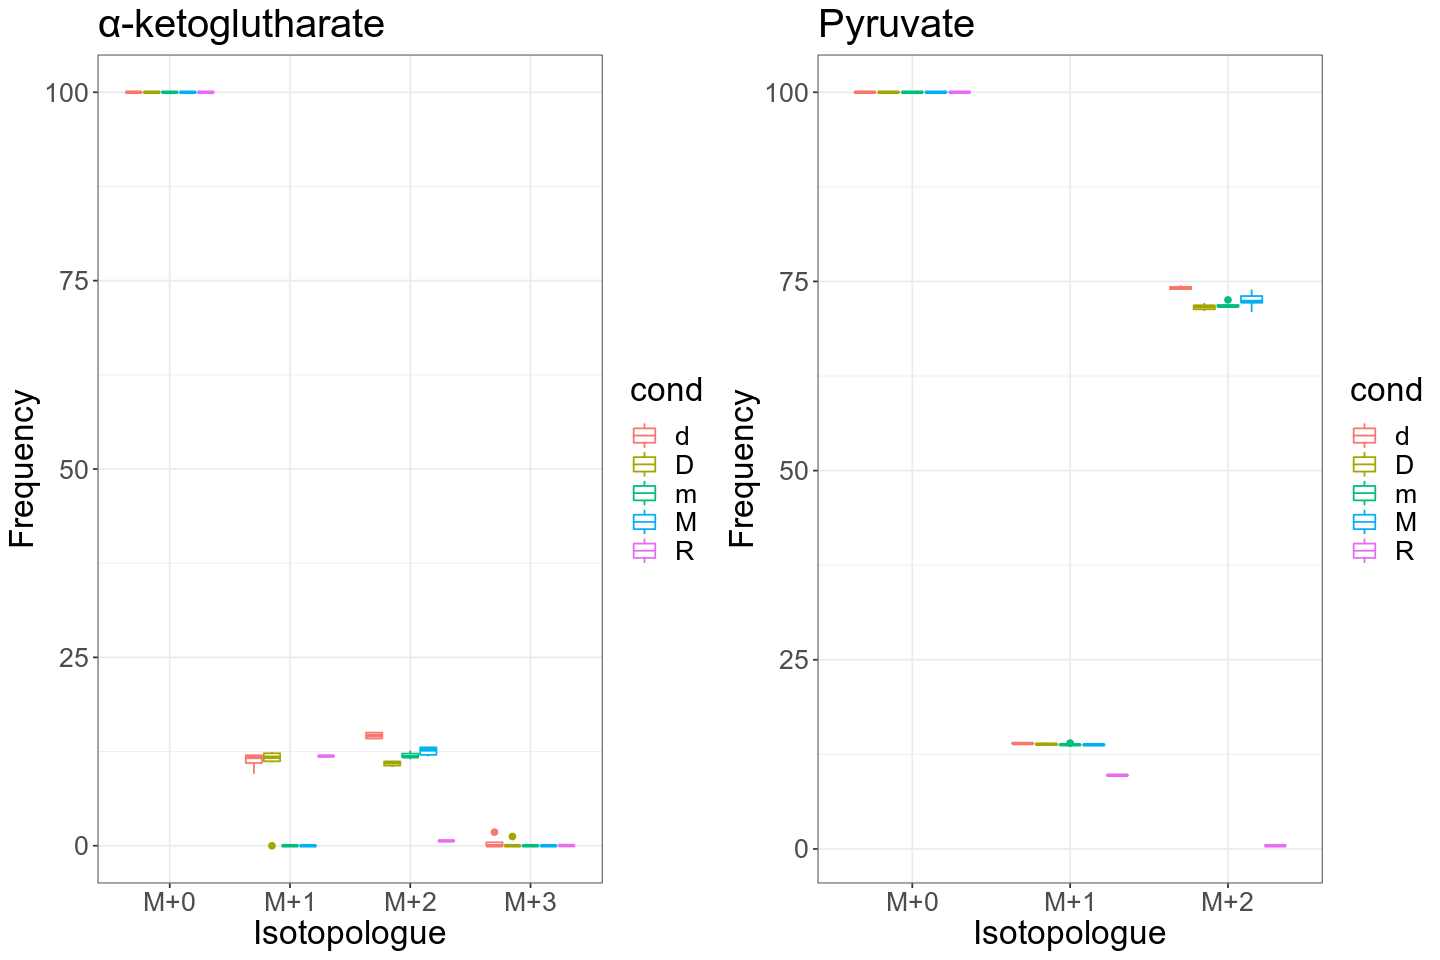

In [81]:
fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}
fig(12,8)
p1 <- akgPlt %>% 
    ggplot( aes(x= ismer, y = value, col = cond) ) +
    geom_boxplot() +  
    ylab("Frequency") + xlab("Isotopologue") + ggtitle('\u03B1-ketoglutharate') +
    theme_bw() + theme(text = element_text(size=20))
p2 <- pyrPlt %>% 
    ggplot( aes(x= ismer, y = value, col = cond) ) +
    geom_boxplot() +  
    ylab("Frequency") + xlab("Isotopologue") + ggtitle('Pyruvate') +
    theme_bw() + theme(text = element_text(size=20))
grid.arrange(p1,p2, ncol=2)